In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# sin波の生成
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

# sin波にノイズを付与する
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

f = toy_problem()

# sin波のデータをRNN用に成形
''' 以下のように25ステップごとにラベルデータ1つで学習データを構成
Train(0) Train( 1 ) ... Train( 24 ) -> Label(0) = Predict(Train( 25 ))
Train(1) Train( 2 ) ... Train( 25 ) -> Label(1) = Predict(Train( 26 ))
  :
Train(t) Train(t+1) ... Train(t+24) -> Label(t) = Predict(Train(t+25))
'''
def make_dataset(low_data, n_prev=100):
    data, target = [], []
    maxlen = 25
    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])
    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)
    return re_data, re_target

# g -> 学習データ，h -> 学習ラベル
g, h = make_dataset(f)

# RNNモデル構築
model = Sequential()
model.add(LSTM(300, batch_input_shape=(None, g.shape[1], 1), return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.001))

# 学習時間の節約のためEarlyStoppingを設定
# 検証データの誤差値が収束してから、更に20エポック語に学習終了
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

# 訓練実行
model.fit(g, h,
          batch_size=300,
          epochs=100,
          validation_split=0.1, # 訓練データのうち10％を検証データとして仕様
          callbacks=[early_stopping]
         )

Using TensorFlow backend.


Train on 158 samples, validate on 18 samples
Epoch 1/100
158/158 [==============================] - 2s 13ms/step - loss: 0.6144 - val_loss: 0.2499
Epoch 2/100
158/158 [==============================] - 0s 320us/step - loss: 0.4605 - val_loss: 0.1291
Epoch 3/100
158/158 [==============================] - 0s 327us/step - loss: 0.3166 - val_loss: 0.0504
Epoch 4/100
158/158 [==============================] - 0s 285us/step - loss: 0.1979 - val_loss: 0.0352
Epoch 5/100
158/158 [==============================] - 0s 308us/step - loss: 0.1182 - val_loss: 0.1198
Epoch 6/100
158/158 [==============================] - 0s 295us/step - loss: 0.1024 - val_loss: 0.2168
Epoch 7/100
158/158 [==============================] - 0s 279us/step - loss: 0.1093 - val_loss: 0.1849
Epoch 8/100
158/158 [==============================] - 0s 270us/step - loss: 0.0797 - val_loss: 0.1032
Epoch 9/100
158/158 [==============================] - 0s 270us/step - loss: 0.0491 - val_loss: 0.0476
Epoch 10/100
158/158 [=======

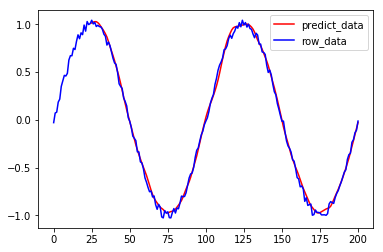

In [3]:
# 予測
pred = model.predict(g) # t=25以降のsin波の波形を予測

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(25,len(pred)+25), pred, color="r", label="predict_data")
plt.plot(range(0, len(f)), f, color="b", label="row_data")
plt.legend()
plt.show()

予測sin波の方は、ほとんどノイズの影響を受けずに予測することができている。

In [4]:
''' 訓練済みモデルによる未来予測 '''
# 学習データの確認
print(g.shape, g[175])

(176, 25, 1) [[-0.97358559]
 [-0.99451851]
 [-0.99347075]
 [-0.99335769]
 [-0.99875935]
 [-0.98157992]
 [-0.8798936 ]
 [-0.85551441]
 [-0.86501695]
 [-0.87443805]
 [-0.8129023 ]
 [-0.76933741]
 [-0.73965267]
 [-0.69122671]
 [-0.64839895]
 [-0.59850464]
 [-0.5462888 ]
 [-0.52226976]
 [-0.41426422]
 [-0.36399013]
 [-0.35029042]
 [-0.23460341]
 [-0.20812188]
 [-0.13496744]
 [-0.10841895]]


In [5]:
# 学習データの1つ先の未来を予測
x = g[175].reshape(1, 25, 1) # 学習データの最後の25個の数値＝特徴量
pred = model.predict(x)
pred

array([[-0.02701224]], dtype=float32)

In [6]:
# 特徴量データを更新
'''
[Data(175) Data(176) ... Data(199)] -> [Data(176) Data(177) ... Data(199) Predict(200)]
'''
x = np.delete(x, 0) # 先頭の数値を削除
x = np.append(x, pred) # 最後尾に予測値を追加
x.reshape(1, 25, 1)

array([[[-0.99451851],
        [-0.99347075],
        [-0.99335769],
        [-0.99875935],
        [-0.98157992],
        [-0.8798936 ],
        [-0.85551441],
        [-0.86501695],
        [-0.87443805],
        [-0.8129023 ],
        [-0.76933741],
        [-0.73965267],
        [-0.69122671],
        [-0.64839895],
        [-0.59850464],
        [-0.5462888 ],
        [-0.52226976],
        [-0.41426422],
        [-0.36399013],
        [-0.35029042],
        [-0.23460341],
        [-0.20812188],
        [-0.13496744],
        [-0.10841895],
        [-0.02701224]]])

In [7]:
# 学習データの2つ先の未来を予測
x = x.reshape(1, 25, 1)
pred = model.predict(x)
pred

array([[0.03072991]], dtype=float32)

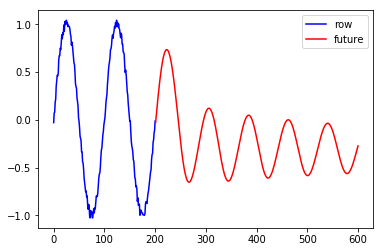

In [8]:
# 学習データ以降のN個の未来を予測
N = 400
future_results = np.empty((0))
x = g[175]

for step in range(N):
    x = x.reshape(1, 25, 1)
    pred = model.predict(x)
    x = np.append(np.delete(x, 0), pred)
    future_results = np.append(future_results, pred)

# sin波をプロット
plt.plot(range(0, len(f)), f, color="b", label="row")
plt.plot(range(0+len(f), len(future_results)+len(f)), future_results, color="r", label="future")
plt.legend()
plt.show()

上図の通り、sin波の予測値は、遠い未来になるほど0に収束していっている。これは学習データの長さ（特徴量の次元数）が短いためと考えられる。そこで、今度は40ステップごとの学習データを作って予測してみる。

In [9]:
def make_dataset(low_data, maxlen=25, n_prev=100):
    data, target = [], []
    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])
    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)
    return re_data, re_target

g, h = make_dataset(f, 40)

model = Sequential()
model.add(LSTM(300, batch_input_shape=(None, g.shape[1], 1), return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.001))

early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(g, h, batch_size=300, epochs=100, validation_split=0.1, callbacks=[early_stopping])

Train on 144 samples, validate on 17 samples
Epoch 1/100
144/144 [==============================] - 1s 6ms/step - loss: 0.5289 - val_loss: 0.1872
Epoch 2/100
144/144 [==============================] - 0s 547us/step - loss: 0.3963 - val_loss: 0.0831
Epoch 3/100
144/144 [==============================] - 0s 547us/step - loss: 0.2709 - val_loss: 0.0292
Epoch 4/100
144/144 [==============================] - 0s 529us/step - loss: 0.1688 - val_loss: 0.0817
Epoch 5/100
144/144 [==============================] - 0s 508us/step - loss: 0.1110 - val_loss: 0.2313
Epoch 6/100
144/144 [==============================] - 0s 505us/step - loss: 0.1080 - val_loss: 0.1942
Epoch 7/100
144/144 [==============================] - 0s 494us/step - loss: 0.0832 - val_loss: 0.0940
Epoch 8/100
144/144 [==============================] - 0s 512us/step - loss: 0.0499 - val_loss: 0.0356
Epoch 9/100
144/144 [==============================] - 0s 505us/step - loss: 0.0338 - val_loss: 0.0134
Epoch 10/100
144/144 [========

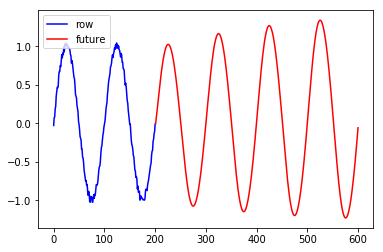

In [10]:
# 学習データ以降のN個の未来を予測
N = 400
future_results = np.empty((0))
x = g[160]

for step in range(N):
    x = x.reshape(1, 40, 1)
    pred = model.predict(x)
    x = np.append(np.delete(x, 0), pred)
    future_results = np.append(future_results, pred)

# sin波をプロット
plt.plot(range(0, len(f)), f, color="b", label="row")
plt.plot(range(0+len(f), len(future_results)+len(f)), future_results, color="r", label="future")
plt.legend()
plt.show()

上図の通り、学習データの長さを増やすことで未来予測は比較的正確になっている。しかし、今度は徐々に拡散してしまっていることから、今回採用したRNNネットワークでは、十分な長さの過去データに対してかなり短い先の未来しか予測できないことが分かる。